In [92]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import pickle
from Bio import Entrez
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from collections import defaultdict
from ast import literal_eval

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Summary:
This notebook will cover obtaining data from **Cancer.Net**, **Pubmed**, **scopus**, **clinicaltrials.gov**, with methods including web scraping, API and Biopython.
<br>https://www.cancer.net/
<br>https://www.ncbi.nlm.nih.gov/pubmed/
<br>https://dev.elsevier.com/
<br>https://clinicaltrials.gov/

# Table of contents
* [1. Obtain information for oncologists from Cancer.Net](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Obtain information for NCI-designated cancer centers](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Obtain information for oncologists](#Part1.2_link)
* [2. Extract publications by oncologists from Pubmed](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Obtain Pubmed ID for each article published by each oncologist](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Extract abstract for each Pubmed ID](#Part2.2_link)
* [3. Extract citation information from scopus](#Part3_link)
* [4. Get information for clinical trials sponsored by oncologists](#Part4_link)
* [5. EDA for oncologists information](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 Number of oncologists in each cancer center](#Part5.1_link)
<br >&nbsp;&nbsp;&nbsp;[5.2 Number of publications by each oncologist](#Part5.2_link)
<br >&nbsp;&nbsp;&nbsp;[5.3 Number of clinical trials by each oncologist](#Part5.3_link)
<br >&nbsp;&nbsp;&nbsp;[5.4 Correlation between articles and clinical trials](#Part5.4_link)
<br >&nbsp;&nbsp;&nbsp;[5.5 Number of citations](#Part5.5_link)

<a id='Part1_link'></a>
# 1. Obtain information for oncologists from Cancer.Net

<a id='Part1.1_link'></a>
## 1.1 Obtain information for NCI-designated cancer centers

The list of 71 NCI-designated cancer centers are downloaded from https://www.cancer.gov/research/nci-role/cancer-centers.

In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
center_df=pd.read_csv(os.path.join(base_dir, 'data/nci_center.csv'))

In [8]:
print('Here are {} NCI-designated cancer centers: \n{}'.format(center_df.center_name.nunique(), center_df.center_name.values))

Here are 71 NCI-designated cancer centers: 
['Abramson Cancer Center ' 'Albert Einstein Cancer Center'
 'Alvin J. Siteman Cancer Center' 'Arizona Cancer Center'
 'Case Comprehensive Cancer Center'
 'Chao Family Comprehensive Cancer Center'
 'City of Hope Comprehensive Cancer Center'
 'Cold Spring Harbor Laboratory Cancer Center'
 'Dan L Duncan Comprehensive Cancer Center'
 'Dana-Farber/Harvard Cancer Center'
 'David H. Koch Institute for Integrative Cancer Research at MIT'
 'Duke Cancer Institute' 'Fox Chase Cancer Center'
 'Fred Hutchinson/University of Washington Cancer Consortium'
 'Fred and Pamela Buffett Cancer Center'
 'Georgetown Lombardi Comprehensive Cancer Center'
 'Harold C. Simmons Comprehensive Cancer Center'
 'Herbert Irving Comprehensive Cancer Center'
 'Holden Comprehensive Cancer Center' 'Hollings Cancer Center'
 'Huntsman Cancer Institute'
 'Indiana University Melvin and Bren Simon Cancer Center'
 'Jonsson Comprehensive Cancer Center' 'Knight Cancer Institute'
 'Laura

<a id='Part1.2_link'></a>
## 1.2 Obtain information for oncologists

Information for oncologists affiliated with the NCI-designated cancer centers are scraped from **Cancer.Net**: https://www.cancer.net/.

In [11]:
def extract_oncologist_info(center_name):
    base_url = 'https://www.cancer.net/find-cancer-doctor?Distance=3&Gender=All&Languages=All&longitude=&latitude=&user_latitude=&user_longitude=&user_address=&searchString={}&search_term={}&search_type=name&url='
    center_name2 = center_name.replace(' Comprehensive Cancer Center', "")
    center_name2 = center_name2.replace(' Cancer Center', "")
    if 'Dana-Farber' in center_name2:
        center_name2='Dana-Farber'
    center_name2 = center_name2.strip().replace(" ","+")
    search_url=base_url.replace("{}",center_name2)
    
    # get html of search results page
    html = requests.get(search_url).content
    soup = BeautifulSoup(html,'html.parser')
    # get list of doctors
    doctors = soup.find_all('li',{'class':'fao-result'})
    if len(doctors)==1:
        print('No doctors have been found for {}'.format(center_name))
        return None
    if len(doctors)>1:
        print('{} doctors have been found for {}'.format(len(doctors), center_name))
    
    # extract information for each doctor
    output=defaultdict(list)
    for doc in doctors:
        ## get name of doctor
        for name in doc.find_all('a',{'class':'fao-result-name-link'}):
            output['name'].append(name.get_text()[:name.get_text().find(',')])
            output['degree'].append(name.get_text()[name.get_text().find(',')+1:])
        ## get phone number of doctor
        for phone in doc.find_all('p',{'class':'fao-result-phone'}):
            output['phone'].append(phone.get_text())
        ## get address of doctor
        for add1 in doc.find_all('p',{'class':'fao-result-address-name'}):
            output['center_name2'].append(add1.get_text())
        add2_output=""
        for add2 in doc.find_all('p',{'class':'fao-result-address-street'}):
            add2_output+=add2.get_text()
        output['address'].append(add2_output)
        for add3 in doc.find_all('p',{'class':'fao-result-address-city_state'}):
            output['city_state'].append(add3.get_text())
        ## get speciality of doctor
        for specialities in doc.find_all('div',{'class':'fao-result-specialties'}):
            sepciality_output=[]
            for speciality in specialities.find_all('p'):
                sepciality_output.append(speciality.get_text())
            output['speciality'].append(sepciality_output)
        ## get certificate of doctor
        for certificates in doc.find_all('div',{'class':'fao-result-certs'}):
            certificate_output=[]
            for certificate in certificates.find_all('p'):
                certificate_output.append(certificate.get_text())
            output['certificate'].append(certificate_output)
    data_df=pd.DataFrame.from_dict(output)
    data_df['center_name']=center_name
    return data_df

In [14]:
def merge_oncologist_info(center_list):
    data_list=[]
    for center_name in center_list:
        data_df=extract_oncologist_info(center_name)
        if data_df is not None:
            data_list.append(data_df)
    return pd.concat(data_list)

In [26]:
center_list=list(center_df.center_name.values)+ list(['Johns Hopkins', 'Cleveland Clinic', 'Massachusetts General Hospital'])
onco_df=merge_oncologist_info(center_list)

13 doctors have been found for Abramson Cancer Center 
17 doctors have been found for Albert Einstein Cancer Center
No doctors have been found for Alvin J. Siteman Cancer Center
50 doctors have been found for Arizona Cancer Center
16 doctors have been found for Case Comprehensive Cancer Center
2 doctors have been found for Chao Family Comprehensive Cancer Center
56 doctors have been found for City of Hope Comprehensive Cancer Center
No doctors have been found for Cold Spring Harbor Laboratory Cancer Center
No doctors have been found for Dan L Duncan Comprehensive Cancer Center
121 doctors have been found for Dana-Farber/Harvard Cancer Center
No doctors have been found for David H. Koch Institute for Integrative Cancer Research at MIT
12 doctors have been found for Duke Cancer Institute
30 doctors have been found for Fox Chase Cancer Center
No doctors have been found for Fred Hutchinson/University of Washington Cancer Consortium
No doctors have been found for Fred and Pamela Buffett Can

In [27]:
onco_df=onco_df[-onco_df.name.duplicated()]

In [29]:
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center
1,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","[Bladder Cancer, Prostate Cancer, Testicular C...",[Medical Oncology],Abramson Cancer Center
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center
3,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center
4,Jeremy S. Abramson,MD,(617) 724-4000,Massachusetts General Hospital,MGH Cancer CtrYawkey Ctr for Outpatient Care,"Boston, MA 02114, US",[],"[Hematology, Internal Medicine, Medical Oncology]",Abramson Cancer Center


In [25]:
print('{} oncologists have been found in cancernet from {} cancer centers'.format(onco_df.shape[0], onco_df.center_name.nunique()))

1470 oncologists have been found in cancernet from 48 cancer centers


<a id='Part2_link'></a>
# 2. Extract publications by oncologists from Pubmed

Articles published by oncologists are available from **Pubmed**.

<a id='Part2.1_link'></a>
## 2.1 Obtain Pubmed ID for each article published by each oncologist

In [31]:
Entrez.email='xieyc10@gmail.com'

In [32]:
num_list=[]
pub_dict=defaultdict(list)

In [33]:
for name in onco_df.name:
    if name not in pub_dict:
        search_term='cancer[MESH] AND {}[AUTH]'.format(name)
        search_handle=Entrez.esearch(db='Pubmed',term=search_term,retmax=1000,idtype="acc")
        search_results = Entrez.read(search_handle)
        search_handle.close()
        num_list.append(int(search_results['Count']))
        pub_dict[name]=search_results['IdList']
        time.sleep(0.5)

Add the number of articles published by each oncologist to the **onco_df**.

In [35]:
onco_df['article_num']=num_list

In [36]:
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","['Breast Cancer', 'Cancer Prevention']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,7
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","['Breast Cancer', 'Geriatrics Oncology']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,0
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","['Breast Cancer', 'Lung Cancer', 'Palliative C...","['Hematology', 'Hospice and Palliative Medicin...",Abramson Cancer Center,13
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","['Bladder Cancer', 'Prostate Cancer', 'Testicu...",['Medical Oncology'],Abramson Cancer Center,86
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","['Clinical Research', 'Developmental Therapeut...",['Medical Oncology'],Abramson Cancer Center,0


In [17]:
onco_df.to_csv(os.path.join(base_dir, "data/Oncologist_info_1470.csv"), index=False)

Delete oncologists that don't have publications based on pubmed from **pub_dict**.

In [40]:
to_del=[]
for i in pub_dict:
    if len(pub_dict[i])==0:
        to_del.append(i)

for i in to_del:
    del pub_dict[i]

In [41]:
print('Number of doctors with publications: {}'.format(len(pub_dict)))

Number of doctors with publications: 1153


In [43]:
### Convert pub_dict to DataFrame
doctor2pmid_1153_dict_df = pd.DataFrame.from_dict(doctor2pmid_dict, orient='index')
doctor2pmid_1153_dict_df['pmid'] = doctor2pmid_1153_dict_df.apply(lambda x:[int(i) for i in x if i is not None],axis=1)
doctor2pmid_1153_dict_df = doctor2pmid_1153_dict_df.loc[:,'pmid'].to_frame()
doctor2pmid_1153_dict_df.head()

,name,pmid
0,John H. Glick,"[19863338, 18621616, 18591552, 15210738, 12712..."
1,David M. Mintzer,"[23233720, 22154117, 20053760, 18758307, 17573..."
2,David J. Vaughn,"[29848605, 29617189, 29590008, 29534941, 29523..."
3,Marcia S. Brose,"[30832606, 29704768, 29657135, 29656442, 29466..."
4,Robert G. Maki,"[31208434, 31142482, 30664786, 30575484, 30383..."


In [57]:
doctor2pmid_1153_dict_df.to_csv(os.path.join(base_dir, 'data/doctor2pmid_1153_dict_df.csv'),index=True,index_label='name')

In [59]:
pub_list=doctor2pmid_1153_dict_df.pmid.sum()
pub_array = np.unique(np.array(pub_list))

In [60]:
print('Total number of unique articles: {}'.format(len(pub_array)))

Total number of unique articles: 57605


<a id='Part2.2_link'></a>
## 2.2 Extract abstract for each Pubmed ID

In [61]:
articletitle_dict = {}
journaltitle_dict = {}
journalabbre_dict = {}
articledate_dict = {}
abstract_dict = {}
articletype_dict = {}

In [ ]:
for i in range(6):
    fetch_handle=Entrez.efetch(db='Pubmed',id=pub_list[i*10000:(i+1)*10000],retmode='xml',rettype='medline')
    fetch_results = Entrez.read(fetch_handle)
    fetch_handle.close()
    for item in fetch_results['PubmedArticle']:
        pmid = item['MedlineCitation']['PMID']
        article = item['MedlineCitation']['Article']
        articletitle_dict[pmid]=article['ArticleTitle']
        journaltitle_dict[pmid]=article['Journal']['Title']
        if 'ISOAbbreviation' in article['Journal']:
            journalabbre_dict[pmid]=article['Journal']['ISOAbbreviation']
    
        if len(article['ArticleDate']) > 0:
            article_date=article['ArticleDate'][0]
            articledate_dict[pmid] = datetime.date(int(article_date['Year']),int(article_date['Month']),int(article_date['Day']))
        elif 'Year' in article['Journal']['JournalIssue']['PubDate']:
            pubdate=article['Journal']['JournalIssue']['PubDate']
            if 'Month' in pubdate:
                if pubdate['Month'].isdigit():
                    date_str=pubdate['Year']+", "+pubdate['Month']
                    articledate_dict[pmid] = datetime.datetime.strptime(date_str, "%Y, %m").date()
                else:
                    date_str=pubdate['Year']+", "+pubdate['Month']
                    articledate_dict[pmid] = datetime.datetime.strptime(date_str, "%Y, %b").date()
            else:
                date_str=pubdate['Year']+", "+'Jan'
                articledate_dict[pmid] = datetime.datetime.strptime(date_str, "%Y, %b").date()
    
        if 'Abstract' in article:
            abstract_dict[pmid]=" ".join(article['Abstract']['AbstractText'])  
        articletype_dict[pmid]=str(article['PublicationTypeList'][0])

In [ ]:
df1 = pd.DataFrame.from_dict(articletitle_dict, orient='index', columns=['article_title'])
df2 = pd.DataFrame.from_dict(journaltitle_dict, orient='index', columns=['journal_title'])
df3 = pd.DataFrame.from_dict(journalabbre_dict, orient='index', columns=['journal_abbre'])
df4 = pd.DataFrame.from_dict(articledate_dict, orient='index', columns=['article_date'])
df5 = pd.DataFrame.from_dict(abstract_dict, orient='index', columns=['abstract'])
df6 = pd.DataFrame.from_dict(articletype_dict, orient='index', columns=['article_type'])

In [ ]:
abstract_df=pd.concat([df1,df2,df3,df4,df5,df6],axis=1,sort=False)

In [ ]:
today = datetime.date.today()

In [ ]:
abstract_df['pub_days']=abstract_df['article_date'].apply(lambda x:(today-x).days if type(x)==datetime.date else np.nan)

In [63]:
abstract_df.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days
pmid,,,,,,,
10037348,In vivo trial comparing patients' tolerance of...,Lasers in surgery and medicine,Lasers Surg Med,1999-01-01,Different types of Q-switched lasers have been...,Clinical Trial,7690.0
10079468,Chronic myelogenous leukemia: update on biolog...,"Oncology (Williston Park, N.Y.)","Oncology (Williston Park, N.Y.)",1999-02-01,Chronic myelogenous leukemia (CML) is a myelop...,Comparative Study,7659.0
10581602,Pain management in patients with advanced pros...,"Oncology (Williston Park, N.Y.)","Oncology (Williston Park, N.Y.)",1999-11-01,Prostate cancer is the most commonly diagnosed...,Journal Article,7386.0
10873802,A human homolog of the C. elegans polarity det...,Current biology : CB,Curr. Biol.,2000-06-01,Rac and Cdc42 are members of the Rho family of...,Journal Article,7173.0
11050493,An in vivo trial comparing the clinical effica...,Dermatologic surgery : official publication fo...,Dermatol Surg,2000-10-01,Q-switched 755 nm alexandrite (QS alex) and Q-...,Clinical Trial,7051.0


In [62]:
abstract_df.to_csv(os.path.join(base_dir, 'data/abstract_df_57605.csv'),index_label='pmid')

In [64]:
abstract_df.describe(include='all')

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days
count,57605,57605,57601,56515,50930,57605,56515.000000
unique,57304,2011,2009,5108,50910,41,NaN
top,Editorial comment.,Journal of clinical oncology : official journa...,J. Clin. Oncol.,2005-01-01,Immunotherapy for cancer refers to a wide arra...,Journal Article,NaN
freq,30,3748,3748,226,2,39401,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2886.088472
std,NaN,NaN,NaN,NaN,NaN,NaN,1727.427447
min,NaN,NaN,NaN,NaN,NaN,NaN,-11.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1421.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2646.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,4221.000000


<a id='Part3_link'></a>
# 3. Extract citation information from scopus

Get articles with abstracts.

In [65]:
abstract_df=abstract_df.dropna(subset=['abstract'])

In [66]:
print("{} articles have abstracts.".format(abstract_df.shape[0]))

50930 articles have abstracts.


In [67]:
abstract_df.to_csv(os.path.join(base_dir, 'data/abstract_df_50930.csv'),index=True,index_label='pmid')

The citations for articles can be obtained from https://dev.elsevier.com/.

In [ ]:
## The apikey here is just an example and needs to be obtained from https://dev.elsevier.com/apikey/manage
apikey='6d0bf6749ccb91c6b8c6979349441ee9'

In [69]:
base_api = 'https://api.elsevier.com/content/search/scopus'

In [70]:
citations = {}

In [71]:
for pmid in abstract_df.index:
    if pmid not in citations:
        query_pmid = 'PMID(' + str(pmid) + ')'
        params = {
        'apiKey': apikey,
        'query': query_pmid,
        'field': 'citedby-count'
    }
        response = requests.get(base_api, params=params)
        response = json.loads(response.text)
        if 'search-results' in response:
            if 'citedby-count' in response['search-results']['entry'][0]:
                citations[pmid]=int(response['search-results']['entry'][0]['citedby-count'])

In [72]:
citation_df=pd.DataFrame.from_dict(citations,orient='index')
citation_df.columns=['citation']

In [77]:
abstract_citation_df=pd.merge(abstract_df, citation_df, left_index=True, right_index=True, how='outer')
abstract_citation_df.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation
pmid,,,,,,,,
2357786,Pseudohypoproteinemia and multiple myeloma.,Cleveland Clinic journal of medicine,Cleve Clin J Med,1990-05-01,Paraproteinemia is an important diagnostic fea...,Case Reports,10857.0,1.0
7512659,Comparison of digital rectal examination and s...,The Journal of urology,J. Urol.,1994-05-01,To compare the efficacy of digital rectal exam...,Clinical Trial,9396.0,1218.0
7523707,Accuracy of digital rectal examination and tra...,The Journal of urology,J. Urol.,1994-11-01,Not all prostate cancers are sonographically h...,Clinical Trial,9212.0,116.0
7525995,Selection of optimal prostate specific antigen...,The Journal of urology,J. Urol.,1994-12-01,A prospective clinical trial of prostate cance...,Clinical Trial,9182.0,230.0
7692657,Effect of patient age on early detection of pr...,Urology,Urology,1993-10-01,This study was designed to determine the effec...,Clinical Trial,9608.0,132.0


In [78]:
print('{} abstracts have citations'.format(abstract_citation_df.citation.notnull().sum()))

49665 abstracts have citations


In [ ]:
abstract_citation_df.to_csv(os.path.join(base_dir, 'data/abstract_citation_df_50930.csv'),index=True,index_label='pmid')

<a id='Part4_link'></a>
# 4. Get information for clinical trials sponsored by oncologists

Clinical trials for each oncologist can be obtained from https://clinicaltrials.gov/.

In [83]:
def get_clinicaltrial_info(onco_name):
    onco_prefix = "+".join(onco_name.split())
    base_api = "https://clinicaltrials.gov/api/query/study_fields?"
    params = {
        'fmt':'JSON',
        'expr':onco_prefix+'+cancer',
        'fields':'NCTId,Condition,BriefTitle,Phase',
        'max_rnk':1000
    }
    response = requests.get(base_api, params=params)
    response = json.loads(response.text)
    num_studies = response['StudyFieldsResponse']['NStudiesFound']
    print('{} has {} studies'.format(onco_name, num_studies))
    num_clinical_trails[onco_name]=num_studies
    
    if num_studies > 0:
        condition_dict=dict()
        title_dict=dict()
        phase_dict=dict()
        for study in response['StudyFieldsResponse']['StudyFields']:
            condition_dict[study['NCTId'][0]] = study['Condition']        
            if len(study['BriefTitle']) > 0:
                title_dict[study['NCTId'][0]] = study['BriefTitle'][0]
            if len(study['Phase']) > 0:
                phase_dict[study['NCTId'][0]] = study['Phase'][0]
    
        df1 = pd.DataFrame.from_dict(condition_dict, orient='index')
        df2 = pd.DataFrame.from_dict(title_dict, orient='index', columns=['BriefTitle'])
        df3 = pd.DataFrame.from_dict(phase_dict, orient='index', columns=['Phase'])
        df1['Condition'] = df1.apply(lambda x:[i for i in x if i is not None],axis=1)
        clinical_df=pd.concat([df2,df3],axis=1,sort=False)
        clinical_df['Condition'] = df1.Condition
        clinical_df.to_csv(os.path.join(base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(onco_prefix)),index=True,index_label='NCTId')

In [84]:
num_clinical_trails=dict()

In [85]:
for onco_name in onco_df.name:
    get_clinicaltrial_info(onco_name)

John H. Glick has 0 studies
Arthur M. Feldman has 1 studies
David M. Mintzer has 0 studies
David J. Vaughn has 1 studies
Charles John Schneider has 5 studies
Marcia S. Brose has 2 studies
Robert G. Maki has 3 studies
Cheryl A. Johnson has 14 studies
Jonathan D. Abramson has 10 studies
Lee P. Hartner has 1 studies
Vandana Gupta Abramson has 0 studies
Jeremy S. Abramson has 7 studies
Maureen R. Hewitt has 0 studies
Richard J. Gralla has 0 studies
Diogo Bugano Diniz Gomes has 0 studies
Mark S. Morginstin has 2 studies
Claudia M. Dourado has 25 studies
Fernando Moura has 0 studies
Vladimir Galvão Aguiar has 0 studies
Rafael Kaliks-Guendelmann has 0 studies
Oren Smaletz has 2 studies
Norma Azzam Grunspun has 0 studies
Haiying Cheng has 1 studies
Heloisa Veasey Rodrigues has 0 studies
Kenneth Lee Zeitzer has 0 studies
Antonio Luiz Frasso has 0 studies
Joseph A. Sparano has 15 studies
Stuart H. Packer has 10 studies
Minal M. Dhamankar has 0 studies
Aditi Shastri has 1 studies
Fabio Pires De S

Pasi A. Janne has 16 studies
Craig A. Bunnell has 5 studies
Lewis B. Silverman has 7 studies
Jerome Ritz has 1 studies
David P. Steensma has 1 studies
Gordon J. Freeman has 13 studies
Daphne A. Haas-Kogan has 2 studies
Edwin Alyea has 3 studies
Heather Anne Parsons has 1 studies
Pedro Sanz-Altamira has 1 studies
Mark M. Awad has 1 studies
Joanne Wolfe has 2 studies
Steven P. Treon has 12 studies
Christopher Sweeney has 7 studies
F. Stephen Hodi has 14 studies
Deborah Schrag has 4 studies
Wendy Y. Chen has 1 studies
Peter C. Enzinger has 11 studies
Michael Nathenson has 1 studies
Kent William Mouw has 0 studies
Beth Overmoyer has 11 studies
Ursula A. Matulonis has 12 studies
Danielle Nina Margalit has 0 studies
James L. Abbruzzese has 4 studies
William R. Berry has 2 studies
Scott Lee Sailer has 0 studies
Tian Zhang has 12 studies
Susan Faye Dent has 0 studies
Tom Stinchcombe has 1 studies
Jeffrey R. Gingrich has 1 studies
Melanie B. Thomas has 6 studies
Steven R. Patierno has 0 studies

Darren R. Feldman has 1 studies
Victoria Susana Blinder has 0 studies
Geoffrey Yuyat Ku has 0 studies
Matthew J. Matasar has 0 studies
Zsofia Kinga Stadler has 0 studies
Karim A. Touijer has 1 studies
Yu Chen has 51 studies
Mila Gorsky has 0 studies
Daniel Costin Danila has 0 studies
Sree Bhavani Chalasani has 0 studies
Alan Loh Ho has 1 studies
Ting Bao has 9 studies
Alison J. Moskowitz has 1 studies
Vicky Makker has 7 studies
Mario E. Lacouture has 6 studies
Roisin Eilish O'Cearbhaill has 0 studies
Oliver Zivanovic has 3 studies
David Randolph Jones has 6 studies
Ping Chi has 4 studies
Michael Ian D'Angelica has 0 studies
Ingo K. Mellinghoff has 1 studies
Carol L. Brown has 15 studies
Harry W. Herr has 2 studies
Nai-Kong V. Cheung has 8 studies
Nancy T. Sklarin has 0 studies
Ellin Berman has 4 studies
Brian H. Kushner has 9 studies
Peter T. Scardino has 0 studies
David A. Scheinberg has 2 studies
Kenneth Offit has 14 studies
Leonard B. Saltz has 16 studies
Isidore Tepler has 0 studie

Adam Steven Asch has 3 studies
Wajeeha Razaq has 5 studies
Cesar Augusto Perez has 0 studies
Craig H. Moskowitz has 1 studies
Ney F. Alves has 0 studies
Jonathan C. Trent has 2 studies
Alejandra T. Perez has 1 studies
Jorge Antunez de Mayolo has 0 studies
Gina Z. D'Amato has 1 studies
Cristiane Takita has 2 studies
Reshma L. Mahtani has 2 studies
Carmen Julia Calfa has 0 studies
Alvaro Jose Alencar has 0 studies
Peter Joel Hosein has 0 studies
Marilyn Huang has 3 studies
Lois Jeanne Ayash has 0 studies
Anthony Frank Shields has 3 studies
Michael S. Simon has 96 studies
Philip Agop Philip has 0 studies
Smit Singla has 0 studies
Gerold Bepler has 7 studies
Voravit Ratanatharathorn has 2 studies
Joseph P. Uberti has 4 studies
Elisabeth I. Heath has 7 studies
Ira Seth Winer has 0 studies
Ammar Sukari has 2 studies
Justin Frank Antoni Klamerus has 0 studies
Abhinav Deol has 2 studies
Sandeep Mittal has 2 studies
Michael R. Grever has 2 studies
Yvonne Adeduni Efebera has 0 studies
Erica Hlav

Quynh Nguyen has 3 studies
Sean Eric Mcguire has 0 studies
Krina K. Patel has 0 studies
Stephen M. Hahn has 3 studies
Miguel A. Rodriguez-Bigas has 1 studies
Paul F. Mansfield has 96 studies
John Michael Skibber has 0 studies
Kenneth V. I. Rolston has 0 studies
David Ira Rosenthal has 0 studies
Michael Robert Migden has 0 studies
Vicente Valero has 5 studies
Nizar M. Tannir has 6 studies
Jeffrey Myers has 53 studies
Gabriel Lopez-Berestein has 1 studies
Ignacio Ivan Wistuba has 0 studies
Christopher Logothetis has 11 studies
Robert C. Bast has 0 studies
Fredrick B. Hagemeister has 0 studies
Nitin Jain has 13 studies
Nicole D. Fleming has 3 studies
Matthew H. G. Katz has 2 studies
Richard E. Champlin has 19 studies
Daniel D. Karp has 6 studies
Jaffer A. Ajani has 21 studies
Jack A. Roth has 2 studies
Bonnie S. Glisson has 8 studies
Eduardo Bruera has 15 studies
Hagop M. Kantarjian has 20 studies
Ann Klopp has 3 studies
Patricia J. Eifel has 1 studies
Alexander J. Lazar has 0 studies
Mar

Charles S. Fuchs has 6 studies
Joseph W. Kim has 24 studies
Terri L. Parker has 1 studies
Justin Persico has 0 studies
Sarah Schellhorn Mougalian has 0 studies
Joseph Paul Eder has 4 studies
Cary Philip Gross has 5 studies
Francine M. Foss has 8 studies
Mario Sznol has 18 studies
Aarti K. Bhatia has 1 studies
Steven Gore has 10 studies
Jaykumar Ranchodbhai Thumar has 0 studies
Ranjit Bindra has 2 studies
Andrea Silber has 2 studies
Patricia LoRusso has 25 studies
Daniel Peter Petrylak has 2 studies
Patrick Aloysius Kenney has 0 studies
Lynn D. Wilson has 9 studies
Barbara Burtness has 7 studies
Jill Lacy has 3 studies
Robert Duffy Legare has 0 studies
Rogerio Lilenbaum has 7 studies
Wajih  Kidwai has 0 studies
Nina Ruth Horowitz has 0 studies
Kevin Kim has 18 studies
Mario A. Eisenberger has 4 studies
Samer Abushullaih has 0 studies
Kala Visvanathan has 1 studies
Julie R. Lange has 0 studies
Lisa K. Jacobs has 1 studies
Mary Y. Armanios has 0 studies
Luis A. Diaz has 34 studies
Jun Luo

In [88]:
num_clinical_trails_df = pd.DataFrame.from_dict(num_clinical_trails, orient='index', columns=['clinical_trial_num']).reset_index().rename(columns={'index':'name'})

In [89]:
onco_df = pd.merge(onco_df, num_clinical_trails_df, left_on='name', right_on='name')
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num
0,John H. Glick,"MD, FASCO",(215) 662-6334,University of Pennsylvania-Abramson Cancer Center,"3400 Civic Center Blvd3rd Fl, Ste 3-300S","Philadelphia, PA 19104-5127, US","['Breast Cancer', 'Cancer Prevention']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,7,0
1,Arthur M. Feldman,MD,(215) 662-9801,University of Pennsylvania-Abramson Cancer Center,Penn Presbyterian Medcl Ctr51 N 39th St MAB St...,"Philadelphia, PA 19104, US","['Breast Cancer', 'Geriatrics Oncology']","['Internal Medicine', 'Medical Oncology']",Abramson Cancer Center,0,1
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","['Breast Cancer', 'Lung Cancer', 'Palliative C...","['Hematology', 'Hospice and Palliative Medicin...",Abramson Cancer Center,13,0
3,David J. Vaughn,MD,(215) 349-8140,University of Pennsylvania-Abramson Cancer Center,PCAM South 10-1143400 Civic Center Blvd,"Philadelphia, PA 19104, US","['Bladder Cancer', 'Prostate Cancer', 'Testicu...",['Medical Oncology'],Abramson Cancer Center,86,1
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",Pereleman Center for Advanced Medicine3400 Civ...,"Philadelphia, PA 19104, US","['Clinical Research', 'Developmental Therapeut...",['Medical Oncology'],Abramson Cancer Center,0,5


In [ ]:
onco_df.to_csv(os.path.join(base_dir, "data/Oncologist_info_clinicaltrial_1470.csv"),index=False)

<a id='Part5_link'></a>
# 5. EDA for oncologists information

<a id='Part5.1_link'></a>
## 5.1 Number of oncologists in each cancer center

In [90]:
onco_counts_df = onco_df.center_name.value_counts().reset_index().rename(columns={'center_name':'counts','index':'center_name'}).sort_values(by=['counts'],ascending=False)
onco_counts_df.head()

,center_name,counts
0,The University of Texas MD Anderson Cancer Center,206
1,Memorial Sloan-Kettering Cancer Center,176
2,Dana-Farber/Harvard Cancer Center,124
3,Mayo Clinic Cancer Center,92
4,City of Hope Comprehensive Cancer Center,57


Text(0.5, 1.0, 'Number of oncologists in each cancer center')

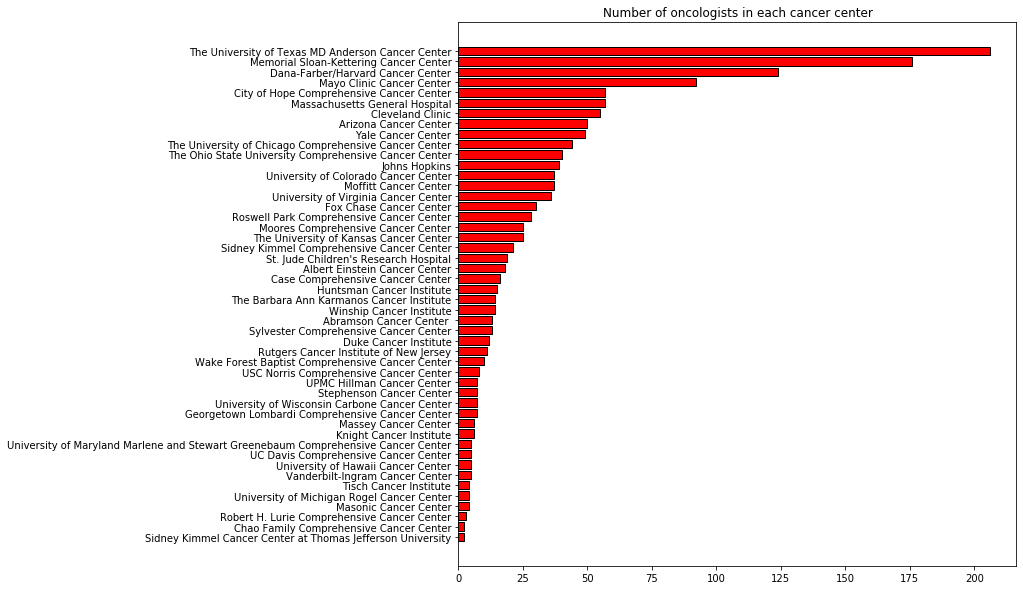

In [98]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.barh(np.arange(48),onco_counts_df.counts.values,edgecolor='black',color='red')

ax.set_yticks(np.arange(48))
ax.set_yticklabels(onco_counts_df.center_name.values)
ax.invert_yaxis()
ax.set_title('Number of oncologists in each cancer center')

In [102]:
print('Cancer centers with the most oncologists are:')
for i in range(5):
    print('Rank {}: {} has {} oncologists'.format(i+1, onco_counts_df.loc[i,'center_name'], onco_counts_df.loc[i,'counts']))

Cancer centers with the most oncologists are:
Rank 1: The University of Texas MD Anderson Cancer Center has 206 oncologists
Rank 2: Memorial Sloan-Kettering Cancer Center has 176 oncologists
Rank 3: Dana-Farber/Harvard Cancer Center has 124 oncologists
Rank 4: Mayo Clinic Cancer Center has 92 oncologists
Rank 5: City of Hope Comprehensive Cancer Center has 57 oncologists


According to **U.S. News & World Report Hospital Rankings & Ratings**, **The University of Texas MD Anderson Cancer Center** ranks 1st in cancer hospitals, **Memorial Sloan-Kettering Cancer Center** ranks 2nd and **Mayo Clinic Cancer Center** ranks 3rd. The number of oncologists affiliated with each cancer center is consitent with the overall ranking of these hospitals.

<a id='Part5.2_link'></a>
## 5.2 Number of publications by each oncologist

In [111]:
print('{} has the highest number of publications {}'.format(onco_df.loc[onco_df.article_num.argmax(),'name'], onco_df.article_num.max()))

Shaachi Gupta has the highest number of publications 9815


In [116]:
onco_df=onco_df.sort_values(by=['article_num'],ascending=False)
onco_df.reset_index(inplace=True)
print('Oncologists with the most publications are:')
for i in range(5):
    print('Rank {}: {} has {} publications'.format(i+1, onco_df.loc[i,'name'], onco_df.loc[i,'article_num']))

Oncologists with the most publications are:
Rank 1: Shaachi Gupta has 9815 publications
Rank 2: Timothy M. Pawlik has 648 publications
Rank 3: Gabriel N. Hortobagyi has 569 publications
Rank 4: Yu Chen has 558 publications
Rank 5: Charles S. Fuchs has 500 publications


Text(0.5, 0, 'log(Number of articles)')

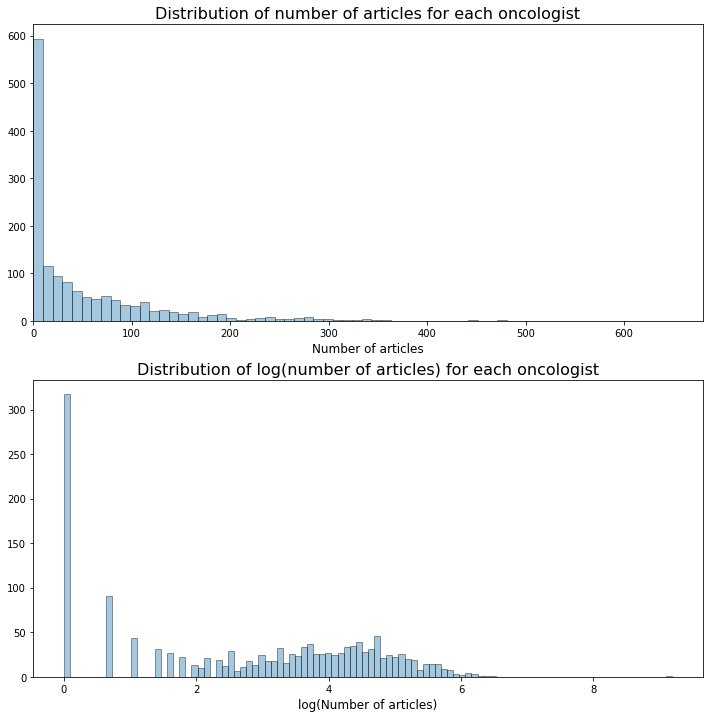

In [130]:
fig,axes=plt.subplots(2,1,figsize=(12,12))
sns.distplot(onco_df.article_num.iloc[1:].values,hist=True,kde=False,bins=1000,ax=axes[0],hist_kws={'edgecolor':'black'})
axes[0].set_xlim(0,680)
axes[0].set_title('Distribution of number of articles for each oncologist',fontsize=16)
axes[0].set_xlabel('Number of articles',fontsize=12)

sns.distplot(np.log(onco_df.article_num.iloc[1:].values+1),hist=True,kde=False,bins=100,ax=axes[1],hist_kws={'edgecolor':'black'})
axes[1].set_title('Distribution of log(number of articles) for each oncologist',fontsize=16)
axes[1].set_xlabel('log(Number of articles)',fontsize=12)

<a id='Part5.3_link'></a>
## 5.3 Number of clinical trials by each oncologist

In [125]:
onco_df=onco_df.sort_values(by=['clinical_trial_num'],ascending=False)
onco_df.reset_index(inplace=True)
print('Oncologists with the most clinical trials are:')
i=1
while i<= 20:
    for index, row in onco_df.head(20).iterrows():
        print('Rank {}: {} has {} clinical trials'.format(i, row['name'], row['clinical_trial_num']))
        i+=1

Oncologists with the most clinical trials are:
Rank 1: John A. Ridge has 716 clinical trials
Rank 2: Howard West has 345 clinical trials
Rank 3: Charles Roberts has 325 clinical trials
Rank 4: Yuan Yuan has 202 clinical trials
Rank 5: Steven Grant has 196 clinical trials
Rank 6: Joseph Chao has 195 clinical trials
Rank 7: James C. Moore has 194 clinical trials
Rank 8: Peter Graham Rose has 181 clinical trials
Rank 9: Robert D. Warren has 175 clinical trials
Rank 10: John C. Barrett has 139 clinical trials
Rank 11: Elizabeth A. Blair has 138 clinical trials
Rank 12: Anne Moore has 129 clinical trials
Rank 13: Michael E. Williams has 122 clinical trials
Rank 14: George H. Perkins has 119 clinical trials
Rank 15: Henry K. Lee has 114 clinical trials
Rank 16: Y. Nancy You has 108 clinical trials
Rank 17: Steven Martin has 107 clinical trials
Rank 18: John D. Mitchell has 101 clinical trials
Rank 19: Lewis R. Roberts has 97 clinical trials
Rank 20: Michael S. Simon has 96 clinical trials


Text(0.5, 0, 'log(Number of clinical trials)')

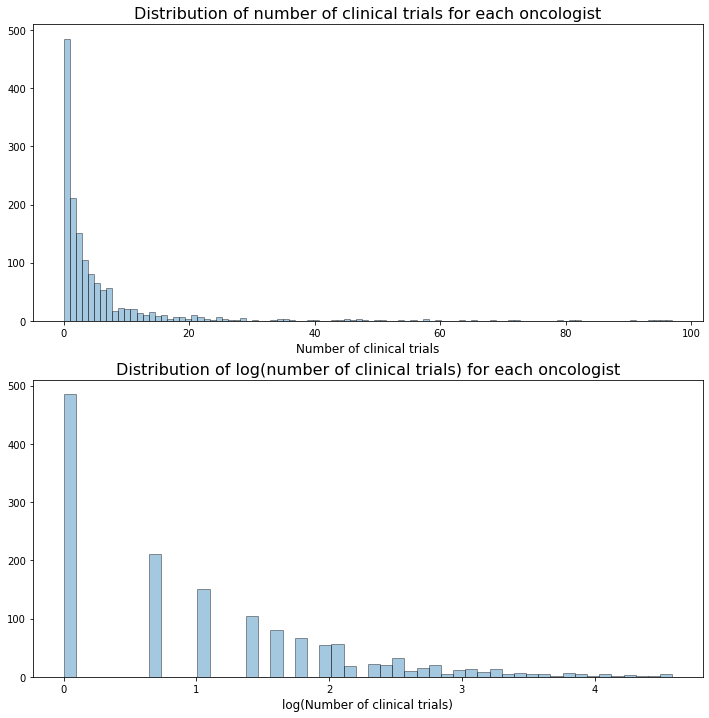

In [138]:
fig,axes=plt.subplots(2,1,figsize=(12,12))
sns.distplot(onco_df.clinical_trial_num.sort_values(ascending=False).iloc[18:].values,hist=True,kde=False,bins=100,ax=axes[0],hist_kws={'edgecolor':'black'})
axes[0].set_title('Distribution of number of clinical trials for each oncologist',fontsize=16)
axes[0].set_xlabel('Number of clinical trials',fontsize=12)

sns.distplot(np.log(onco_df.clinical_trial_num.sort_values(ascending=False).iloc[18:].values+1),hist=True,kde=False,bins=50,ax=axes[1],hist_kws={'edgecolor':'black'})
axes[1].set_title('Distribution of log(number of clinical trials) for each oncologist',fontsize=16)
axes[1].set_xlabel('log(Number of clinical trials)',fontsize=12)

<a id='Part5.4_link'></a>
## 5.4 Correlation between articles and clinical trials

In [150]:
subset_df=onco_df.loc[:,['article_num', 'clinical_trial_num']]
subset_df['article_num_log'] = np.log(subset_df.article_num+1)
subset_df['clinical_trial_num_log'] = np.log(subset_df.clinical_trial_num+1)

Text(0, 0.5, 'log(Number of clinical trials)')

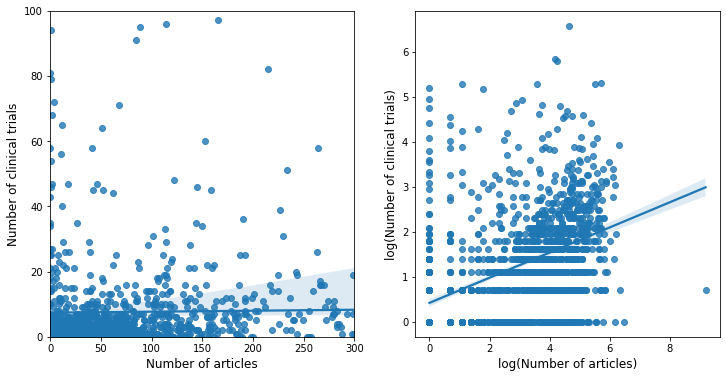

In [152]:
fig, axes = plt.subplots(1,2,figsize = (12,6))
sns.regplot(x='article_num',y='clinical_trial_num',data=subset_df,ax=axes[0])
axes[0].set_xlim(0,300)
axes[0].set_ylim(0,100)
axes[0].set_xlabel('Number of articles', fontsize=12)
axes[0].set_ylabel('Number of clinical trials', fontsize=12)

sns.regplot(x='article_num_log',y='clinical_trial_num_log',data=subset_df,ax=axes[1])
#axes[0].set_xlim(0,300)
#axes[0].set_ylim(0,100)
axes[1].set_xlabel('log(Number of articles)', fontsize=12)
axes[1].set_ylabel('log(Number of clinical trials)', fontsize=12)

<a id='Part5.5_link'></a>
## 5.5 Number of citations

In [136]:
print('Highest number of citations for an article: {}'.format(int(abstract_citation_df.citation.max())))

Highest number of citations for an article: 8317


Text(0.5, 0, 'log(number of citations)')

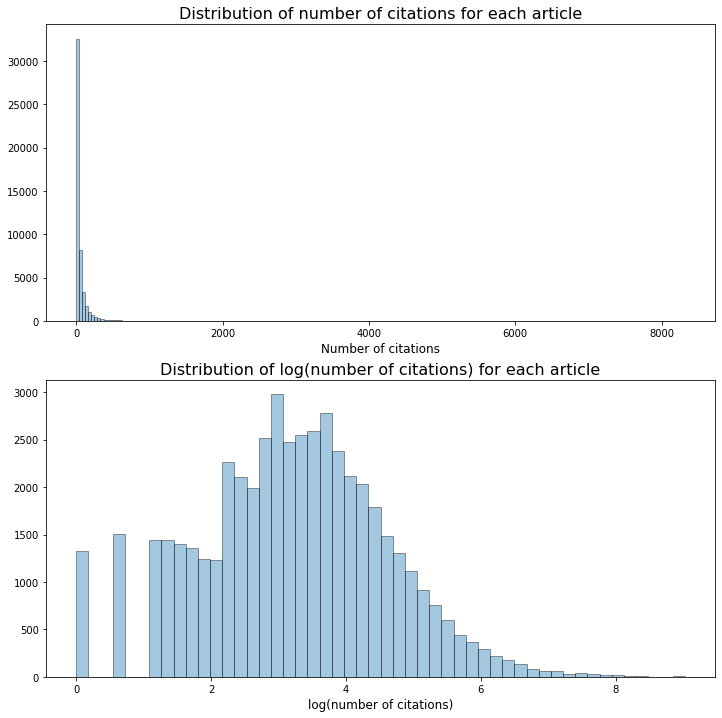

In [142]:
fig,axes=plt.subplots(2,1,figsize=(12,12))
sns.distplot(abstract_citation_df.citation.values,hist=True,kde=False,bins=200,ax=axes[0],hist_kws={'edgecolor':'black'})
axes[0].set_title('Distribution of number of citations for each article',fontsize=16)
axes[0].set_xlabel('Number of citations',fontsize=12)

sns.distplot(np.log(abstract_citation_df.citation.values+1),hist=True,kde=False,bins=50,ax=axes[1],hist_kws={'edgecolor':'black'})
axes[1].set_title('Distribution of log(number of citations) for each article',fontsize=16)
axes[1].set_xlabel('log(number of citations)',fontsize=12)